<a href="https://colab.research.google.com/github/OpenMLCo/TensorRT-Yolo-Deepsort/blob/main/Cambio_de_fondo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tripmap cambio de fondo


In [ ]:
!pip3 install pymatting

     |████████████████████████████████| 46 kB 1.8 MB/s 


In [ ]:
#!git clone https://github.com/pymatting/pymatting
%cd pymatting
!pip install .

/content/pymatting
Processing /content/pymatting
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for PyMatting: filename=PyMatting-1.1.4-py3-none-any.whl size=46274 sha256=86ab8f2fd55dfce7f37508a949446b2ba1deef01d4a991cf2fbb05c9f8011f42
  Stored in directory: /tmp/pip-ephem-wheel-cache-zrr77q08/wheels/ed/3b/0f/7cfae9fa553daccd116dca3e3030ee426d890b18fc177dc4c0
Successfully built PyMatting
  Attempting uninstall: PyMatting
    Found existing installation: PyMatting 1.1.4
    Uninstalling PyMatting-1.1.4:
      Successfully uninstalled PyMatting-1.1.4


In [ ]:
ls

benchmarks/      data/       pymatting/              requirements.txt
CHANGELOG.md     doc/        README.md               setup.py
CONTRIBUTING.md  examples/   requirements_gpu.txt    tests/
CONTRIBUTORS.md  LICENSE.md  requirements_tests.txt


In [ ]:
ls data/lemur/

beach.png               lemur_color_bleeding.png  lemur.png
lemur_alpha.png         lemur_cutout.png          lemur_trimap.png
lemur_at_the_beach.png  lemur_foreground.png
lemur_background.png    lemur_grid.png


In [ ]:
from pymatting import cutout

cutout(
    # input image path
    "data/lemur/lemur.png",
    # input trimap path
    "data/lemur/lemur_trimap.png",
    # output cutout path
    "lemur_cutout.png")

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
import numpy as np

In [ ]:
mask = np.loadtxt('/content/pymatting/data/0asd.txt')

In [ ]:
import matplotlib.pyplot as plt
import cv2

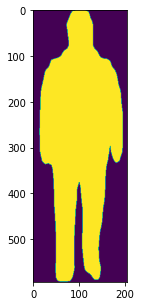

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(mask)

In [ ]:
kernel = np.ones((5, 5), np.uint8)
foreground = cv2.erode(mask, kernel)
foreground = cv2.erode(foreground, kernel)
foreground = cv2.erode(foreground, kernel)

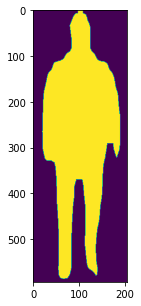

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(foreground)

In [ ]:
kernel = np.ones((10, 10), np.uint8)
nose = cv2.dilate(mask, kernel)
nose = nose-foreground
Trimap = np.zeros_like(mask)+foreground+nose*0.5

In [ ]:
Trimap = np.zeros_like(mask)+foreground+nose*0.5

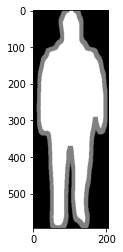

In [ ]:
plt.imshow(Trimap,cmap='gray')

In [ ]:
cv2.imwrite('/content/pymatting/data/trimap.png',Trimap*255)

True

In [ ]:
from pymatting import cutout

cutout(
    # input image path
    "/content/pymatting/data/person.jpg",
    # input trimap path
    "/content/pymatting/data/trimap.jpg",
    # output cutout path
    "/content/pymatting/data/tales_2.png")

# Cambio de fondo

In [ ]:
%cd /content/drive/MyDrive/La_victoria_Caldas_jetson_nano/Codes_Victoria_vision/Matting image

/content/drive/.shortcut-targets-by-id/1GipOC8Hz3e8AtmT9OmZTTsRd2lSIVq8A/Codes_Victoria_vision/Matting image


In [ ]:
ls

backgroun.jpeg               person.jpg  tales.jpg   trimap.png
Deep-Image-Matting-PyTorch/  person.png  trimap.jpg


In [ ]:
#!git clone https://github.com/foamliu/Deep-Image-Matting-PyTorch.git

In [ ]:
%cd Deep-Image-Matting-PyTorch/

/content/drive/.shortcut-targets-by-id/1GipOC8Hz3e8AtmT9OmZTTsRd2lSIVq8A/Codes_Victoria_vision/Matting image/Deep-Image-Matting-PyTorch


In [ ]:
import math

import random
import cv2 as cv
import numpy as np
import torch
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from config import device, fg_path_test, a_path_test, bg_path_test
from data_gen import data_transforms, fg_test_files, bg_test_files
from utils import compute_mse, compute_sad, AverageMeter, get_logger


def gen_test_names():
    num_fgs = 50
    num_bgs = 1000
    num_bgs_per_fg = 20

    names = []
    bcount = 0
    for fcount in range(num_fgs):
        for i in range(num_bgs_per_fg):
            names.append(str(fcount) + '_' + str(bcount) + '.png')
            bcount += 1

    return names


def process_test(im_name, bg_name, trimap):
    # print(bg_path_test + bg_name)
    im = cv.imread(im_name)
    a = cv.imread(im_name, 0)
    h, w = im.shape[:2]
    bg = cv.imread(bg_name)
    bh, bw = bg.shape[:2]
    wratio = w / bw
    hratio = h / bh
    ratio = wratio if wratio > hratio else hratio
    if ratio > 1:
        bg = cv.resize(src=bg, dsize=(math.ceil(bw * ratio), math.ceil(bh * ratio)), interpolation=cv.INTER_CUBIC)

    return composite4_test(im, bg, a, w, h, trimap)

def composite4(fg, bg, a, w, h):
    print(fg.shape, bg.shape, a.shape, w, h)
    fg = np.array(fg, np.float32)
    bg_h, bg_w = bg.shape[:2]
    x = 0
    if bg_w > w:
        x = np.random.randint(0, bg_w - w)
    y = 0
    if bg_h > h:
        y = np.random.randint(0, bg_h - h)
    bg = np.array(bg[y:y + h, x:x + w], np.float32)
    alpha = np.zeros((h, w, 1), np.float32)
    alpha[:, :, 0] = a
    im = alpha * fg + (1 - alpha) * bg
    im = im.astype(np.uint8)
    return im, bg

# def composite4_test(fg, bg, a, w, h):
#     fg = np.array(fg, np.float32)
#     bg_h, bg_w = bg.shape[:2]
#     x = max(0, int((bg_w - w)/2))
#     y = max(0, int((bg_h - h)/2))
#     bg = np.array(bg[y:y + h, x:x + w], np.float32)
#     alpha = np.zeros((h, w, 1), np.float32)
#     alpha[:, :, 0] = a / 255.
#     im = alpha * fg + (1 - alpha) * bg
#     im = im.astype(np.uint8)
#     print('im.shape: ' + str(im.shape))
#     print('a.shape: ' + str(a.shape))
#     print('fg.shape: ' + str(fg.shape))
#     print('bg.shape: ' + str(bg.shape))
#     return im, a, fg, bg

def gen_trimap(alpha):
    k_size = random.choice(range(1, 5))
    iterations = np.random.randint(1, 20)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (k_size, k_size))
    dilated = cv.dilate(alpha, kernel, iterations)
    eroded = cv.erode(alpha, kernel, iterations)
    trimap = np.zeros(alpha.shape)
    trimap.fill(128)
    trimap[eroded >= 255] = 255
    trimap[dilated <= 0] = 0
    return trimap

def composite4_test(fg, bg, a, w, h, trimap):
    fg = np.array(fg, np.float32)
    bg_h, bg_w = bg.shape[:2]
    x = max(0, int((bg_w - w) / 2))
    y = max(0, int((bg_h - h) / 2))
    crop = np.array(bg[y:y + h, x:x + w], np.float32)
    alpha = np.zeros((h, w, 1), np.float32)
    alpha[:, :, 0] = a / 255.
    # trimaps = np.zeros((h, w, 1), np.float32)
    # trimaps[:,:,0]=trimap/255.

    im = alpha * fg + (1 - alpha) * crop
    im = im.astype(np.uint8)

    new_a = np.zeros((bg_h, bg_w), np.uint8)
    new_a[y:y + h, x:x + w] = a
    new_trimap = np.zeros((bg_h, bg_w), np.uint8)
    new_trimap[y:y + h, x:x + w] = trimap
    cv.imwrite('images/test/new/tripmap_new.png', new_trimap)
    new_im = bg.copy()
    new_im[y:y + h, x:x + w] = im
    # cv.imwrite('images/test/new_im/'+trimap_name,new_im)
    return new_im, new_a, fg, bg, new_trimap, y, y + h, x, x + w

In [ ]:
checkpoint = 'BEST_checkpoint.tar'
checkpoint = torch.load(checkpoint)
model = checkpoint['model'].module
model = model.to(device)
model.eval()
transformer = data_transforms['valid']

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attri

In [ ]:
trimap = cv.imread('/content/drive/MyDrive/La_victoria_Caldas_jetson_nano/Codes_Victoria_vision/Matting image/trimap.png', 0)
im_name = '/content/drive/MyDrive/La_victoria_Caldas_jetson_nano/Codes_Victoria_vision/Matting image/person.jpg'
bg_name = '/content/drive/MyDrive/La_victoria_Caldas_jetson_nano/Codes_Victoria_vision/Matting image/backgroun.jpeg'
img, alpha, fg, bg, new_trimap,y_2,yh, x_2,xw = process_test(im_name, bg_name, trimap)

In [ ]:
h, w = img.shape[:2]
trimap = gen_trimap(alpha)
# mytrimap = gen_trimap(alpha)
# cv.imwrite('images/test/new_im/'+trimap_name,mytrimap)

x = torch.zeros((1, 4, h, w), dtype=torch.float)
img = img[..., ::-1]  # RGB
img = transforms.ToPILImage()(img)  # [3, 320, 320]
img = transformer(img)  # [3, 320, 320]
x[0:, 0:3, :, :] = img
x[0:, 3, :, :] = torch.from_numpy(new_trimap.copy() / 255.)

# Move to GPU, if available
x = x.type(torch.FloatTensor).to(device)  # [1, 4, 320, 320]
alpha = alpha / 255.

with torch.no_grad():
    pred = model(x)  # [1, 4, 320, 320]

pred = pred.cpu().numpy()
pred = pred.reshape((h, w))  # [320, 320]

pred[new_trimap == 0] = 0.0
pred[new_trimap == 255] = 1.0
#cv.imwrite('/content/drive/MyDrive/La_victoria_Caldas_jetson_nano/Codes_Victoria_vision/Matting image/tales.jpg', pred * 255)


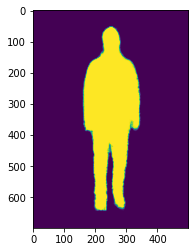

In [ ]:
plt.imshow(pred)

In [ ]:
im_i= cv.imread(im_name)
bg_i=   cv.imread(bg_name)
#im_i_rgb = cv.cvtColor(im_i, cv.COLOR_BGR2RGB)

#bg_i_rgb = cv.cvtColor(bg_i, cv.COLOR_BGR2RGB)

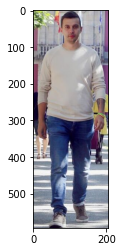

In [ ]:
plt.imshow(im_i_rgb)

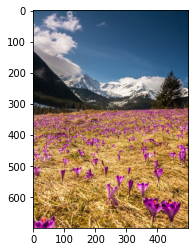

In [ ]:
plt.imshow(bg_i_rgb)

In [ ]:
pred_3d = pred[:,:,np.newaxis]

352

In [ ]:
final = bg_i
final[y_2:yh, x_2:xw] = bg_i[y_2:yh, x_2:xw]*(1-pred_3d[y_2:yh, x_2:xw])+im_i*(pred_3d[y_2:yh, x_2:xw])
final=final.astype(np.uint8)
cv.imwrite('/content/drive/MyDrive/La_victoria_Caldas_jetson_nano/Codes_Victoria_vision/Matting image/tales.jpg',final)
final_rgb = cv.cvtColor(final, cv.COLOR_BGR2RGB)

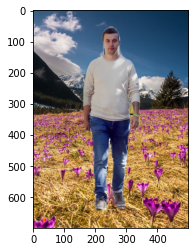

In [ ]:
plt.imshow(final_rgb)